In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.processes import Piecewise
from IPython.display import HTML

import nengo_loihi

import pandas as pd

In [8]:
model = nengo.Network(label="Multidirectional Nav Dynamics")
with model:
    # Create the recurrent neuron ensemble
    D = nengo.Ensemble(400, dimensions=6)

    # Create piecewise acceleration control input
    # Note, I am initializing BOTH directions as the exact same dynamics from the past two parts
    # That way, you can confirm everything is connected properly first
    # inputs = [[.5, .5], [0, 0], [-1, -1], [0, 0], [1, 1], [0,0]]
    inputs = [
        [0, 0.5],
        [0, -0.5],
        [0.5, 0],
        [-0.5, 0],
        [0, -0.5],
        [0, 0.5],
        [0.5, 0],
        [-0.5, 0],
    ]
    #          [north],  [brakes], [east] , [brakes], [south], [brakes], [east], [brakes]
    process = nengo.processes.PresentInput(inputs, presentation_time=1)
    accel_input = nengo.Node(process)

    # input_accelX = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))
    # input_accelY = nengo.Node(Piecewise({0: 0, 0.2: 1, 1: 0, 2: -2, 3: 0, 4: 1, 5: 0}))

    # Using a long time constant for stability (less noise)
    tau = 0.8

    feedback_matrix = [
        [1, 0, tau, 0, 0, 0],
        [0, 1, 0, tau, 0, 0],
        [0, 0, 1, 0, tau, 0],
        [0, 0, 0, 1, 0, tau],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ]
    print(feedback_matrix)
    nengo.Connection(D, D, transform=feedback_matrix, synapse=tau)

    feedfwd_matrix = [[0, 0], [0, 0], [0, 0], [0, 0], [tau, 0], [0, tau]]
    # print(feedfwd_matrix)

    nengo.Connection(accel_input, D, transform=feedfwd_matrix, synapse=tau)

[[1, 0, 0.8, 0, 0, 0], [0, 1, 0, 0.8, 0, 0], [0, 0, 1, 0, 0.8, 0], [0, 0, 0, 1, 0, 0.8], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

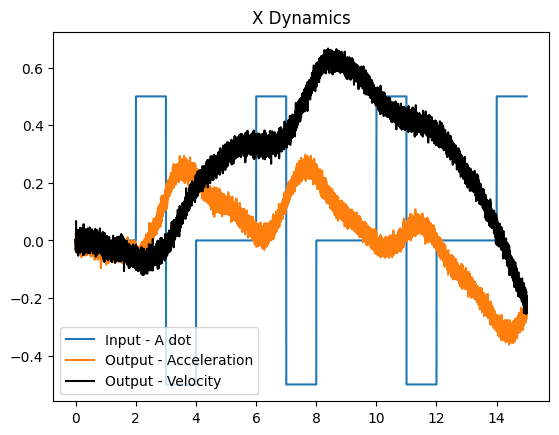

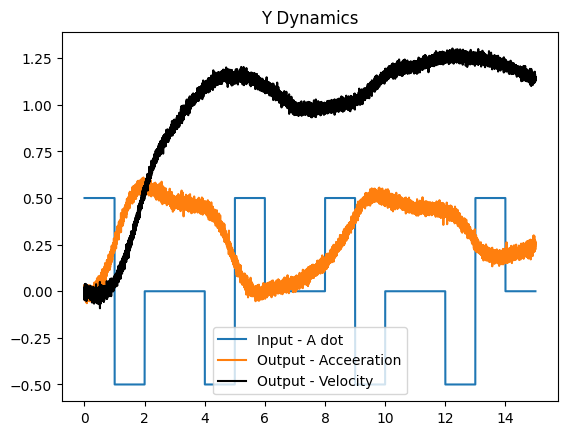

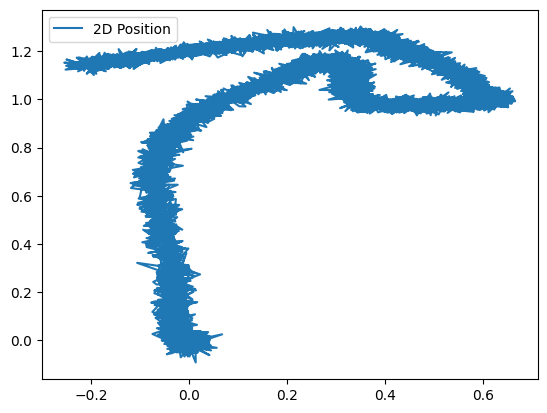

In [9]:
with model:
    # Probe and run
    # Add probes
    input_probe = nengo.Probe(accel_input)
    output_probe = nengo.Probe(D, synapse=0.01)

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 10 seconds
    sim.run(15)

plt.figure()
plt.plot(sim.trange(), sim.data[input_probe][:, 0], label="Input - A dot")
plt.plot(sim.trange(), sim.data[output_probe][:, 2], label="Output - Acceleration")
plt.plot(sim.trange(), sim.data[output_probe][:, 0], "k", label="Output - Velocity")
plt.legend()
plt.title("X Dynamics")

# Plot the decoded outputs
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe][:, 1], label="Input - A dot")
plt.plot(sim.trange(), sim.data[output_probe][:, 3], label="Output - Acceeration")
plt.plot(sim.trange(), sim.data[output_probe][:, 1], "k", label="Output - Velocity")
plt.legend()
plt.title("Y Dynamics")

# Plot the birds-eye view of position
plt.figure()
plt.plot(
    sim.data[output_probe][:, 0], sim.data[output_probe][:, 1], label="2D Position"
)
plt.legend()

In [30]:
data = []
true_trajectory = pd.read_csv("kf_true_trajectory 2.csv").set_index("t")
t = 0
dt = 1
timemax = 119999
data_1 = true_trajectory.loc[t]  # single event
while t < timemax:

    data.append(true_trajectory.loc[t * 0.001])
    t += dt

    # indexing with a decimal returns error after index value 9

KeyError: 0.009000000000000001

In [31]:
class readData:
    def __init__(self, funct):
        self.vals = funct

    def step(self, t):

        self.vals = np.roll(self.vals, -1)
        return self.vals[0]


inp = readData(data_1)  # read data from the single event only

model = nengo.Network(label="ReadData")

# Create a model to perform the sorting
with model:

    # Add input node
    input_node = nengo.Node(inp.step)

    # Add a single neuron to encode the input
    input_neuron = nengo.Ensemble(n_neurons=100, dimensions=1)

    # Connect the node to the encoding neuron
    inp_conn = nengo.Connection(input_node, input_neuron)

    ## Add probes to see outputs throughout the model
    # This probe captures the non-spiking input value
    input_probe_node = nengo.Probe(input_node)

    # This probe displays the decoded neural representation of the input
    input_probe_neuron = nengo.Probe(input_neuron, synapse=0.01)

    # Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Decoded Spikes = Neural Representation of Input')

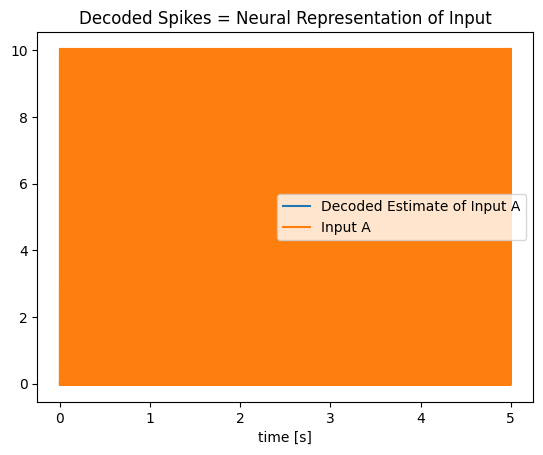

In [32]:
# Plot the input signals and decoded ensemble values
plt.figure()
plt.plot(
    sim.trange(), sim.data[input_probe_neuron], label="Decoded Estimate of Input A"
)
# uncomment next line to see the mean value versus the actual value
plt.plot(sim.trange(), sim.data[input_probe_node], label="Input A")
plt.legend()
plt.xlabel("time [s]")
plt.title("Decoded Spikes = Neural Representation of Input")